<a href="https://colab.research.google.com/github/RaminTK/Job-Shop/blob/main/RL_JobShop_Aug_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
import random
import matplotlib.pyplot as plt

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
policy_net = PolicyNet(input_size, hidden_size, output_size).to(device)


# # FT06 dataset
# jobs_data = [
#     [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
#     [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
#     [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
#     [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
#     [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
#     [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
# ]


# FT20 dataset
# OPTIMAL SOL = 1165
jobs_data = [
    [(0,29),(1,9),(2,49),(3,62),(4,44)],
    [(0,43),(1,75),(3,69),(2,46),(4,72)],
    [(1,91),(0,39),(2,90),(4,12),(3,45)],
    [(1,81),(0,71),(4,9),(2,85),(3,22)],
    [(2,14),(1,22),(0,26),(3,21),(4,72)],
    [(2,84),(1,52),(4,48),(0,47),(3,6)],
    [(1,46),(0,61),(2,32),(3,32),(4,30)],
    [(2,31),(1,46),(0,32),(3,19),(4,36)],
    [(0,76),(3,76),(2,85),(1,40),(4,26)],
    [(1,85),(2,61),(0,64),(3,47),(4,90)],
    [(1,78),(3,36),(0,11),(4,56),(2,21)],
    [(2,90),(0,11),(1,28),(3,46),(4,30)],
    [(0,85),(2,74),(1,10),(3,89),(4,33)],
    [(2,95),(0,99),(1,52),(3,98),(4,43)],
    [(0,6),(1,61),(4,69),(2,49),(3,53)],
    [(1,2),(0,95),(3,72),(4,65),(2,25)],
    [(0,37),(2,13),(1,21),(3,89),(4,55)],
    [(0,86),(1,74),(4,88),(2,48),(3,79)],
    [(1,69),(2,51),(0,11),(3,89),(4,74)],
    [(0,13),(1,7),(2,76),(3,52),(4,45)],
]

n_jobs = len(jobs_data)
n_machines = 5
ops_per_job = len(jobs_data[0])
total_ops = n_jobs * ops_per_job

# ---------------- Environment ----------------
class JobShopEnv:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.reset()

    def reset(self):
        self.machine_times = [0] * n_machines
        self.job_times = [0] * n_jobs
        self.op_indices = [0] * n_jobs
        self.done_ops = 0
        return self._get_state()

    def _get_state(self):
        return np.array(self.op_indices + self.machine_times, dtype=np.float32)


    def step(self, job):
        if self.op_indices[job] >= ops_per_job:
            # still discourage illegal actions a bit
            return self._get_state(), -1.0, False

        prev_makespan = max(self.job_times)

        op_idx = self.op_indices[job]
        machine, duration = self.jobs_data[job][op_idx]
        start = max(self.machine_times[machine], self.job_times[job])
        finish = start + duration

        self.machine_times[machine] = finish
        self.job_times[job] = finish
        self.op_indices[job] += 1
        self.done_ops += 1

        new_makespan = max(self.job_times)
        step_increase = new_makespan - prev_makespan
        reward = -step_increase  # dense reward = negative makespan increment

        done = self.done_ops >= total_ops
        return self._get_state(), reward, done


# ---------------- Policy Network ----------------
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.pi = nn.Linear(hidden_size, output_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, x, mask=None):
        h = self.body(x)
        logits = self.pi(h)

        if mask is not None:
            # set logits of invalid actions to a large negative
            logits = logits + (mask.log() if (mask > 0).all() else torch.log(mask + 1e-8))

        probs = torch.softmax(logits, dim=-1)
        value = self.v(h).squeeze(-1)
        return probs, value


# ---------------- Training ----------------
env = JobShopEnv(jobs_data)
input_size = len(env._get_state())
hidden_size = 64
output_size = n_jobs

policy_net = PolicyNet(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

n_epochs = 2000
best_makespan = float('inf')
best_policy_seq = None

for epoch in range(n_epochs):
    log_probs = []
    rewards = []

    state = env.reset()
    done = False
    seq = []

    while not done:
        # state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)

        probs = policy_net(state_t).squeeze(0)

        mask = torch.tensor([1.0 if env.op_indices[j] < ops_per_job else 0.0 for j in range(n_jobs)],
                            dtype=torch.float32)
        masked_probs = probs * mask
        masked_probs = torch.clamp(masked_probs, min=0.0)

        if masked_probs.sum().item() <= 1e-8:
            valid_jobs = [j for j in range(n_jobs) if env.op_indices[j] < ops_per_job]
            job = random.choice(valid_jobs)
        else:
            masked_probs = masked_probs / masked_probs.sum()
            m = torch.distributions.Categorical(masked_probs)
            job = m.sample().item()
            log_probs.append(m.log_prob(torch.tensor(job)))

        seq.append(job)
        state, reward, done = env.step(job)
        rewards.append(reward)

    # total_reward = rewards[-1] if rewards else -9999
    total_reward = sum(rewards) if rewards else -9999


    if log_probs:
        loss = -torch.stack(log_probs).sum() * total_reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    makespan = -total_reward
    if makespan > 0 and makespan < best_makespan:
        best_makespan = makespan
        best_policy_seq = seq.copy()

    # print(f"Epoch {epoch}, Makespan = {makespan}")

if best_policy_seq:
    print("Best Makespan:", best_makespan)
    print("Best Sequence:", best_policy_seq[:20])
else:
    print("No valid schedule found.")



# ---------------- Gantt Chart ----------------
def plot_gantt(seq, jobs_data, best_makespan):
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

if best_policy_seq:
    plot_gantt(best_policy_seq, jobs_data, best_makespan)

Using device: cpu


NameError: name 'PolicyNet' is not defined

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
import random
import matplotlib.pyplot as plt

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# FT06 dataset
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]


# # FT20 dataset
# # OPTIMAL SOL = 1165
# jobs_data = [
#     [(0,29),(1,9),(2,49),(3,62),(4,44)],
#     [(0,43),(1,75),(3,69),(2,46),(4,72)],
#     [(1,91),(0,39),(2,90),(4,12),(3,45)],
#     [(1,81),(0,71),(4,9),(2,85),(3,22)],
#     [(2,14),(1,22),(0,26),(3,21),(4,72)],
#     [(2,84),(1,52),(4,48),(0,47),(3,6)],
#     [(1,46),(0,61),(2,32),(3,32),(4,30)],
#     [(2,31),(1,46),(0,32),(3,19),(4,36)],
#     [(0,76),(3,76),(2,85),(1,40),(4,26)],
#     [(1,85),(2,61),(0,64),(3,47),(4,90)],
#     [(1,78),(3,36),(0,11),(4,56),(2,21)],
#     [(2,90),(0,11),(1,28),(3,46),(4,30)],
#     [(0,85),(2,74),(1,10),(3,89),(4,33)],
#     [(2,95),(0,99),(1,52),(3,98),(4,43)],
#     [(0,6),(1,61),(4,69),(2,49),(3,53)],
#     [(1,2),(0,95),(3,72),(4,65),(2,25)],
#     [(0,37),(2,13),(1,21),(3,89),(4,55)],
#     [(0,86),(1,74),(4,88),(2,48),(3,79)],
#     [(1,69),(2,51),(0,11),(3,89),(4,74)],
#     [(0,13),(1,7),(2,76),(3,52),(4,45)],
# ]

n_jobs = len(jobs_data)
n_machines = 6
ops_per_job = len(jobs_data[0])
total_ops = n_jobs * ops_per_job

# ---------------- Environment ----------------
class JobShopEnv:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.reset()

    def reset(self):
        self.machine_times = [0] * n_machines
        self.job_times = [0] * n_jobs
        self.op_indices = [0] * n_jobs
        self.done_ops = 0
        return self._get_state()

    def _get_state(self):
        return np.array(self.op_indices + self.machine_times, dtype=np.float32)


    def step(self, job):
        if self.op_indices[job] >= ops_per_job:
            # still discourage illegal actions a bit
            return self._get_state(), -1.0, False

        prev_makespan = max(self.job_times)

        op_idx = self.op_indices[job]
        machine, duration = self.jobs_data[job][op_idx]
        start = max(self.machine_times[machine], self.job_times[job])
        finish = start + duration

        self.machine_times[machine] = finish
        self.job_times[job] = finish
        self.op_indices[job] += 1
        self.done_ops += 1

        new_makespan = max(self.job_times)
        step_increase = new_makespan - prev_makespan
        reward = -step_increase  # dense reward = negative makespan increment

        done = self.done_ops >= total_ops
        return self._get_state(), reward, done


# ---------------- Policy Network ----------------


class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.pi = nn.Linear(hidden_size, output_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, x, mask=None):
        h = self.body(x)
        logits = self.pi(h)

        if mask is not None:
            # set logits of invalid actions to a large negative
            logits = logits + (mask.log() if (mask > 0).all() else torch.log(mask + 1e-8))

        probs = torch.softmax(logits, dim=-1)
        value = self.v(h).squeeze(-1)
        return probs, value


# ---------------- Training ----------------
env = JobShopEnv(jobs_data)
input_size = len(env._get_state())
hidden_size = 64
output_size = n_jobs




# policy_net = PolicyNet(input_size, hidden_size, output_size)
policy_net = PolicyNet(input_size, hidden_size, output_size).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=3e-4)
entropy_coef = 0.01
value_coef = 0.5
gamma = 1.0
max_grad_norm = 1.0

n_epochs = 2000
best_makespan = float('inf')
best_policy_seq = None

for epoch in range(n_epochs):
    log_probs, values, rewards, entropies = [], [], [], []
    state = env.reset()
    done = False
    seq = []
    print(epoch)
    while not done:
        # state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)

        mask = torch.tensor([1.0 if env.op_indices[j] < ops_per_job else 0.0 for j in range(n_jobs)],
                            dtype=torch.float32, device=device).unsqueeze(0)

        probs, V = policy_net(state_t, mask = mask.to(device))
        probs = probs.squeeze(0); V = V.squeeze(0)

        if probs.sum().item() <= 1e-8:
            valid_jobs = [j for j in range(n_jobs) if env.op_indices[j] < ops_per_job]
            job = random.choice(valid_jobs)
            log_prob = torch.tensor(0.0); entropy = torch.tensor(0.0, device=device)
        else:
            m = torch.distributions.Categorical(probs)
            job = m.sample().item()
            log_prob = m.log_prob(torch.tensor(job, device=device))
            entropy = m.entropy()

        seq.append(job)
        state, reward, done = env.step(job)

        log_probs.append(log_prob)
        values.append(V)
        rewards.append(torch.tensor(reward, dtype=torch.float32, device=device))
        entropies.append(entropy)

    returns = []
    G = torch.tensor(0.0, device=device)
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns.reverse()
    returns = torch.stack(returns)

    values = torch.stack(values)
    advantages = returns - values.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    policy_loss = -(torch.stack(log_probs) * advantages).sum()
    value_loss = value_coef * (returns - values).pow(2).mean()
    entropy_bonus = entropy_coef * torch.stack(entropies).mean()

    loss = policy_loss + value_loss - entropy_bonus
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
    optimizer.step()

    makespan = -sum(r.item() for r in rewards)
    if makespan > 0 and makespan < best_makespan:
        best_makespan = makespan
        best_policy_seq = seq.copy()


if best_policy_seq:
    print("Best Makespan:", best_makespan)
    print("Best Sequence:", best_policy_seq[:20])
else:
    print("No valid schedule found.")



# ---------------- Gantt Chart ----------------
def plot_gantt(seq, jobs_data, best_makespan):
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

if best_policy_seq:
    plot_gantt(best_policy_seq, jobs_data, best_makespan)

Using device: cpu
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


KeyboardInterrupt: 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------- Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- Dataset ----------------
# FT06
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]

n_jobs = len(jobs_data)
ops_per_job = len(jobs_data[0])
n_machines = max(m for job in jobs_data for m, _ in job) + 1
total_ops = n_jobs * ops_per_job

# ---------------- Environment ----------------
class JobShopEnv:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.reset()

    def reset(self):
        self.machine_times = [0] * n_machines
        self.job_times = [0] * n_jobs
        self.op_indices = [0] * n_jobs
        self.done_ops = 0
        return np.array(self.op_indices + self.machine_times, dtype=np.float32)

    def step(self, job):
        if self.op_indices[job] >= ops_per_job:
            return self._get_state(), -1.0, False

        prev_makespan = max(self.job_times)
        op_idx = self.op_indices[job]
        machine, duration = self.jobs_data[job][op_idx]
        start = max(self.machine_times[machine], self.job_times[job])
        finish = start + duration

        self.machine_times[machine] = finish
        self.job_times[job] = finish
        self.op_indices[job] += 1
        self.done_ops += 1

        new_makespan = max(self.job_times)
        step_increase = new_makespan - prev_makespan
        reward = -step_increase
        done = self.done_ops >= total_ops
        return self._get_state(), reward, done

    def _get_state(self):
        return np.array(self.op_indices + self.machine_times, dtype=np.float32)

# ---------------- Policy Network ----------------
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.pi = nn.Linear(hidden_size, output_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, x, mask=None):
        h = self.body(x)
        logits = self.pi(h)
        if mask is not None:
            logits = logits + (mask + 1e-8).log()  # -inf where invalid
        probs = torch.softmax(logits, dim=-1)
        value = self.v(h).squeeze(-1)
        return probs, value

# ---------------- Training ----------------
env = JobShopEnv(jobs_data)
input_size = len(env._get_state())
hidden_size = 128
output_size = n_jobs

policy_net = PolicyNet(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=3e-4)
entropy_coef = 0.01
value_coef = 0.5
gamma = 1.0
max_grad_norm = 1.0

n_epochs = 200      # fewer epochs (but with batches)
batch_size = 32     # parallel rollouts
best_makespan = float('inf')
best_policy_seq = None

for epoch in range(n_epochs):
    print(epoch)
    batch_log_probs, batch_values, batch_rewards, batch_entropies = [], [], [], []
    batch_makespans, batch_seqs = [], []

    # Run multiple episodes in batch
    for ep in range(batch_size):
        log_probs, values, rewards, entropies = [], [], [], []
        state = env.reset()
        done = False
        seq = []

        while not done:
            state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
            mask = torch.tensor(
                [1.0 if env.op_indices[j] < ops_per_job else 0.0 for j in range(n_jobs)],
                dtype=torch.float32, device=device
            ).unsqueeze(0)

            probs, V = policy_net(state_t, mask=mask)
            probs, V = probs.squeeze(0), V.squeeze(0)

            if probs.sum().item() <= 1e-8:
                valid_jobs = [j for j in range(n_jobs) if env.op_indices[j] < ops_per_job]
                job = random.choice(valid_jobs)
                log_prob = torch.tensor(0.0, device=device)
                entropy = torch.tensor(0.0, device=device)
            else:
                m = torch.distributions.Categorical(probs)
                job = m.sample().item()
                log_prob = m.log_prob(torch.tensor(job, device=device))
                entropy = m.entropy()

            seq.append(job)
            state, reward, done = env.step(job)

            log_probs.append(log_prob)
            values.append(V)
            rewards.append(torch.tensor(reward, dtype=torch.float32, device=device))
            entropies.append(entropy)

        returns, G = [], torch.tensor(0.0, device=device)
        for r in reversed(rewards):
            G = r + gamma * G
            returns.append(G)
        returns.reverse()
        returns = torch.stack(returns)

        values = torch.stack(values)
        advantages = returns - values.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        batch_log_probs.append(torch.stack(log_probs))
        batch_values.append(values)
        batch_rewards.append(returns)
        batch_entropies.append(torch.stack(entropies))

        makespan = -sum(r.item() for r in rewards)
        batch_makespans.append(makespan)
        batch_seqs.append(seq)

    # Combine batch
    log_probs = torch.cat(batch_log_probs)
    values = torch.cat(batch_values)
    returns = torch.cat(batch_rewards)
    entropies = torch.cat(batch_entropies)

    advantages = returns - values.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    policy_loss = -(log_probs * advantages).sum()
    value_loss = value_coef * (returns - values).pow(2).mean()
    entropy_bonus = entropy_coef * entropies.mean()
    loss = policy_loss + value_loss - entropy_bonus

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
    optimizer.step()

    avg_makespan = np.mean(batch_makespans)
    if min(batch_makespans) < best_makespan:
        idx = int(np.argmin(batch_makespans))
        best_makespan = batch_makespans[idx]
        best_policy_seq = batch_seqs[idx]

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Avg Makespan {avg_makespan:.1f} | Best {best_makespan:.1f}")

print("Final Best Makespan:", best_makespan)


Using device: cpu
0


KeyboardInterrupt: 

In [ ]:
# ---------------- Gantt Chart ----------------
def plot_gantt(seq, jobs_data, best_makespan):
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

if best_policy_seq:
    plot_gantt(best_policy_seq, jobs_data, best_makespan)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- Dataset ----------------
# FT06 dataset (6 jobs × 6 machines)
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]

n_jobs = len(jobs_data)
ops_per_job = len(jobs_data[0])
n_machines = 6
total_ops = n_jobs * ops_per_job

# Convert jobs_data to tensor (jobs × ops × 2)
jobs_data = torch.tensor(jobs_data, device=device)

# ---------------- Environment ----------------
class JobShopEnv:
    def __init__(self, jobs_data, batch_size=32):
        self.jobs_data = jobs_data
        self.n_jobs, self.ops_per_job, _ = jobs_data.shape
        self.n_machines = n_machines
        self.total_ops = self.n_jobs * self.ops_per_job
        self.batch_size = batch_size
        self.reset()

    def reset(self):
        self.machine_times = torch.zeros((self.batch_size, self.n_machines), device=device)
        self.job_times = torch.zeros((self.batch_size, self.n_jobs), device=device)
        self.op_indices = torch.zeros((self.batch_size, self.n_jobs), dtype=torch.long, device=device)
        self.done_ops = torch.zeros(self.batch_size, dtype=torch.long, device=device)
        return self._get_state()

    def _get_state(self):
        # concatenate op indices + machine times
        return torch.cat([self.op_indices.float(), self.machine_times], dim=1)

    def step(self, jobs):
        b_idx = torch.arange(self.batch_size, device=device)
        op_idx = self.op_indices[b_idx, jobs]

        valid = op_idx < self.ops_per_job
        machine = self.jobs_data[jobs, op_idx, 0]
        duration = self.jobs_data[jobs, op_idx, 1].float()

        start = torch.max(self.machine_times[b_idx, machine], self.job_times[b_idx, jobs])
        finish = start + duration

        # update if valid
        self.machine_times[b_idx, machine] = torch.where(valid, finish, self.machine_times[b_idx, machine])
        self.job_times[b_idx, jobs] = torch.where(valid, finish, self.job_times[b_idx, jobs])
        self.op_indices[b_idx, jobs] = torch.where(valid, op_idx+1, op_idx)
        self.done_ops += valid.long()

        # reward: penalize duration only if valid
        reward = -(finish - start) * valid.float()

        done = self.done_ops >= self.total_ops
        return self._get_state(), reward, done

# ---------------- Policy Network ----------------
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.pi = nn.Linear(hidden_size, output_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, x, mask=None):
        h = self.body(x)
        logits = self.pi(h)

        if mask is not None:
            # set invalid logits to -inf
            logits = logits.masked_fill(mask == 0, -1e9)

        probs = torch.softmax(logits, dim=-1)
        value = self.v(h).squeeze(-1)
        return probs, value

# ---------------- Training ----------------
batch_size = 32
env = JobShopEnv(jobs_data, batch_size=batch_size)
input_size = env._get_state().shape[1]
hidden_size = 128
output_size = n_jobs

policy_net = PolicyNet(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=3e-4)

entropy_coef = 0.01
value_coef = 0.5
gamma = 1.0
max_grad_norm = 1.0

n_epochs = 2000
best_makespan = float('inf')

for epoch in range(n_epochs):
    log_probs, values, rewards, entropies = [], [], [], []
    state = env.reset()
    done = torch.zeros(batch_size, dtype=torch.bool, device=device)

    while not done.all():
        mask = (env.op_indices < ops_per_job).float()
        probs, V = policy_net(state, mask=mask)

        # sample jobs only from valid probs
        m = torch.distributions.Categorical(probs)
        jobs = m.sample()

        log_prob = m.log_prob(jobs)
        entropy = m.entropy()

        state, reward, done = env.step(jobs)

        log_probs.append(log_prob)
        values.append(V)
        rewards.append(reward)
        entropies.append(entropy)

    # returns
    returns = []
    G = torch.zeros(batch_size, device=device)
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns.reverse()
    returns = torch.stack(returns)

    values = torch.stack(values)
    log_probs = torch.stack(log_probs)
    entropies = torch.stack(entropies)

    advantages = returns - values.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    policy_loss = -(log_probs * advantages).sum()
    value_loss = value_coef * (returns - values).pow(2).mean()
    entropy_bonus = entropy_coef * entropies.mean()

    loss = policy_loss + value_loss - entropy_bonus
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
    optimizer.step()

    # track makespan
    makespan = env.job_times.max(dim=1).values.mean().item()
    if makespan < best_makespan:
        best_makespan = makespan

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Makespan={makespan:.2f}, Best={best_makespan:.2f}")

print("Training finished. Best Makespan:", best_makespan)


Using device: cpu
Epoch 0, Avg Makespan=127.72, Best=127.72
Epoch 100, Avg Makespan=123.19, Best=116.31
Epoch 200, Avg Makespan=142.41, Best=115.28
Epoch 300, Avg Makespan=137.44, Best=115.28
Epoch 400, Avg Makespan=134.53, Best=115.28
Epoch 500, Avg Makespan=139.94, Best=115.28
Epoch 600, Avg Makespan=140.34, Best=115.28


KeyboardInterrupt: 

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time

# Set device for GPU acceleration if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.machine_schedules = [[] for _ in range(self.n_machines)]
        self.machine_times = [0] * self.n_machines
        self.job_progress = [0] * self.n_jobs  # Next operation index for each job
        self.job_completion_times = [0] * self.n_jobs
        self.completed_operations = set()
        self.step_count = 0
        return self.get_state()

    def get_valid_actions(self):
        """Get list of valid job indices that can be scheduled next"""
        valid_actions = []
        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                valid_actions.append(job_id)
        return valid_actions

    def get_state(self):
        """Get current state representation"""
        # Normalized state vector
        state = []

        # Machine utilization (normalized by max time)
        max_time = max(self.machine_times) if max(self.machine_times) > 0 else 1
        state.extend([t / max_time for t in self.machine_times])

        # Job progress (normalized)
        state.extend([p / self.n_machines for p in self.job_progress])

        # Next operation info for each job
        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                state.extend([machine / self.n_machines, duration / 20.0])  # Normalize duration
            else:
                state.extend([0, 0])  # Job completed

        # Add makespan so far
        state.append(max(self.machine_times) / 100.0)  # Normalized makespan

        return np.array(state, dtype=np.float32)

    def step(self, action):
        """Execute action (schedule job) and return new state, reward, done"""
        if action not in self.get_valid_actions():
            return self.get_state(), -100, False  # Invalid action penalty

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        # Schedule operation
        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_schedules[machine].append((job_id, operation_idx, start_time, end_time))
        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.step_count += 1

        # Check if all jobs are completed
        done = all(progress >= self.n_machines for progress in self.job_progress)

        # Calculate reward
        if done:
            makespan = max(self.machine_times)
            reward = 200 - makespan  # Higher reward for lower makespan
        else:
            # Intermediate reward based on utilization and progress
            avg_utilization = np.mean(self.machine_times)
            progress_reward = sum(self.job_progress) / (self.n_jobs * self.n_machines) * 10
            reward = progress_reward - avg_utilization * 0.1

        return self.get_state(), reward, done

    def get_makespan(self):
        """Get current makespan"""
        return max(self.machine_times)

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(DuelingDQN, self).__init__()

        # Shared feature extractor
        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)

        # Combine value and advantage using dueling architecture
        q_values = values + advantages - advantages.mean(dim=-1, keepdim=True)
        return q_values

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = deque(maxlen=capacity)
        self.position = 0

        self.Experience = namedtuple('Experience',
                                   ['state', 'action', 'reward', 'next_state', 'done'])

    def add(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.priorities else 1.0

        experience = self.Experience(state, action, reward, next_state, done)

        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience

        self.priorities.append(max_priority)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) < batch_size:
            return None

        # Convert priorities to probabilities
        priorities = np.array(list(self.priorities)[:len(self.buffer)])
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        # Sample indices based on priorities
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        # Calculate importance sampling weights
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        # Extract experiences
        experiences = [self.buffer[idx] for idx in indices]

        states = torch.FloatTensor([e.state for e in experiences]).to(device)
        actions = torch.LongTensor([e.action for e in experiences]).to(device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(device)
        dones = torch.BoolTensor([e.done for e in experiences]).to(device)
        weights = torch.FloatTensor(weights).to(device)

        return states, actions, rewards, next_states, dones, weights, indices

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

class JobShopDQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim

        # Networks
        self.q_network = DuelingDQN(state_dim, action_dim).to(device)
        self.target_network = DuelingDQN(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.990
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.target_update_freq = 100

        # Experience replay
        self.memory = PrioritizedReplayBuffer(10000)
        self.update_count = 0

        # Copy weights to target network
        self.update_target_network()

    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def choose_action(self, state, valid_actions):
        """Choose action using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)

            # Mask invalid actions
            masked_q_values = q_values.clone()
            for i in range(self.action_dim):
                if i not in valid_actions:
                    masked_q_values[0, i] = float('-inf')

            return masked_q_values.argmax().item()

    def train(self):
        """Train the network using prioritized experience replay"""
        batch = self.memory.sample(self.batch_size)
        if batch is None:
            return

        states, actions, rewards, next_states, dones, weights, indices = batch

        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Next Q values from target network (Double DQN)
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1))
            target_q_values = rewards.unsqueeze(1) + (self.gamma * next_q_values * ~dones.unsqueeze(1))

        # Calculate losses
        td_errors = current_q_values - target_q_values
        losses = (td_errors ** 2) * weights.unsqueeze(1)
        loss = losses.mean()

        # Update priorities
        priorities = abs(td_errors.detach().cpu().numpy().flatten()) + 1e-6
        self.memory.update_priorities(indices, priorities)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_jobshop_rl(jobs_data, episodes=2000):
    """Train RL agent on job shop problem"""
    env = JobShopEnvironment(jobs_data)

    # Calculate state dimension
    state_dim = len(env.get_state())
    action_dim = env.n_jobs

    agent = JobShopDQNAgent(state_dim, action_dim)

    # Training metrics
    episode_rewards = []
    makespans = []
    best_makespan = float('inf')
    best_episode = 0

    print(f"Training DQN agent for {episodes} episodes...")
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")

    start_time = time.time()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)

            # Store experience
            agent.memory.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train agent
            if len(agent.memory.buffer) > agent.batch_size:
                agent.train()

        makespan = env.get_makespan()
        episode_rewards.append(total_reward)
        makespans.append(makespan)

        # Track best solution
        if makespan < best_makespan:
            best_makespan = makespan
            best_episode = episode

        # Progress reporting
        if episode % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_makespan = np.mean(makespans[-100:])
            print(f"Episode {episode}/{episodes}, Avg Reward: {avg_reward:.2f}, "
                  f"Avg Makespan: {avg_makespan:.2f}, Best: {best_makespan}, Epsilon: {agent.epsilon:.3f}")

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Best makespan: {best_makespan} (Episode {best_episode})")

    return agent, episode_rewards, makespans, best_makespan

def evaluate_agent(agent, jobs_data, num_runs=10):
    """Evaluate trained agent"""
    makespans = []

    for run in range(num_runs):
        env = JobShopEnvironment(jobs_data)
        state = env.reset()
        done = False

        # Use greedy policy (no exploration)
        agent.epsilon = 0

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = agent.choose_action(state, valid_actions)
            state, _, done = env.step(action)

        makespans.append(env.get_makespan())

    return makespans

def plot_training_progress(episode_rewards, makespans):
    """Plot training progress"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Moving average for smoothing
    window = 50
    if len(episode_rewards) >= window:
        smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        smoothed_makespans = np.convolve(makespans, np.ones(window)/window, mode='valid')

        ax1.plot(smoothed_rewards)
        ax1.set_title('Training Rewards (Smoothed)')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')

        ax2.plot(smoothed_makespans)
        ax2.set_title('Makespan Progress (Smoothed)')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Makespan')
    else:
        ax1.plot(episode_rewards)
        ax1.set_title('Training Rewards')
        ax2.plot(makespans)
        ax2.set_title('Makespan Progress')

    plt.tight_layout()
    plt.show()

# ---------------- Dataset ----------------
# FT06 dataset (6 jobs × 6 machines)
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]

# ---------------- Main Execution ----------------
if __name__ == "__main__":
    print("🚀 Starting Job Shop Scheduling with Deep Reinforcement Learning")
    print("=" * 60)

    # Train the agent
    agent, rewards, makespans, best_makespan = train_jobshop_rl(jobs_data, episodes=3000)

    # Evaluate the trained agent
    print("\n📊 Evaluating trained agent...")
    eval_makespans = evaluate_agent(agent, jobs_data, num_runs=20)

    print(f"\nEvaluation Results (20 runs):")
    print(f"Mean makespan: {np.mean(eval_makespans):.2f}")
    print(f"Best makespan: {min(eval_makespans)}")
    print(f"Std deviation: {np.std(eval_makespans):.2f}")

    # Known optimal for FT06 is 55
    optimal_ft06 = 55
    print(f"\nOptimal makespan for FT06: {optimal_ft06}")
    print(f"Gap from optimal: {min(eval_makespans) - optimal_ft06}")
    print(f"Optimality gap: {((min(eval_makespans) - optimal_ft06) / optimal_ft06 * 100):.2f}%")

    # Plot results
    plot_training_progress(rewards, makespans)

    print("\n✅ Training and evaluation completed!")

Using device: cpu
🚀 Starting Job Shop Scheduling with Deep Reinforcement Learning
Training DQN agent for 3000 episodes...
State dimension: 25, Action dimension: 6
Episode 0/3000, Avg Reward: 118.12, Avg Makespan: 106.00, Best: 106, Epsilon: 1.000


KeyboardInterrupt: 

Using device: cpu
🎯 Optimized Job Shop RL Solver
🚀 Fast RL Training - Target: 55
State dim: 25, Action dim: 6
Episode 0: Best=71, Recent Avg=71.0, Epsilon=0.992
Episode 100: Best=71, Recent Avg=128.7, Epsilon=0.050
Episode 200: Best=71, Recent Avg=123.9, Epsilon=0.050
Episode 300: Best=71, Recent Avg=120.2, Epsilon=0.050
Episode 400: Best=71, Recent Avg=125.8, Epsilon=0.050
Episode 500: Best=71, Recent Avg=143.8, Epsilon=0.050
Early stopping due to stagnation at episode 501

✅ Training completed in 72.2 seconds
🏆 Best makespan achieved: 71
📊 Gap from optimal: 16

📊 Final Evaluation...

🏁 FINAL RESULTS:
Best makespan: 147
Average makespan: 147.00
Success rate (≤60): 0.0%
Optimal rate (≤55): 0.0%


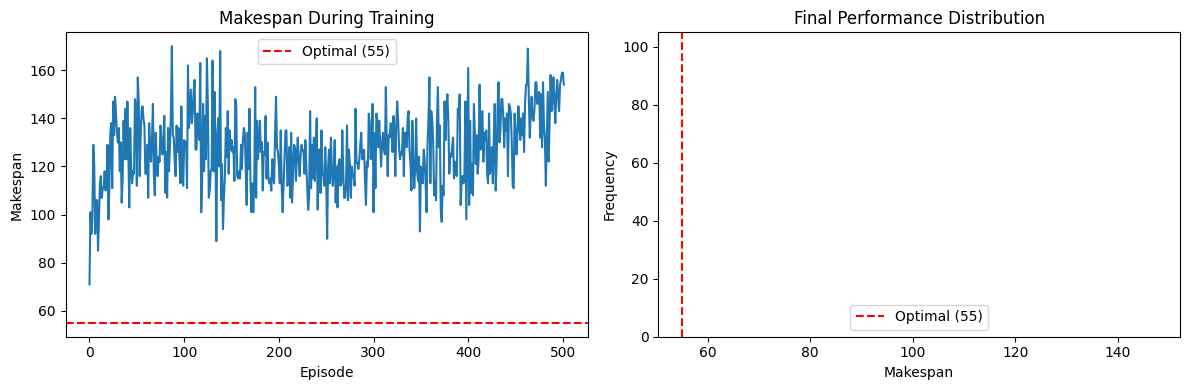


📈 Generating Gantt chart...


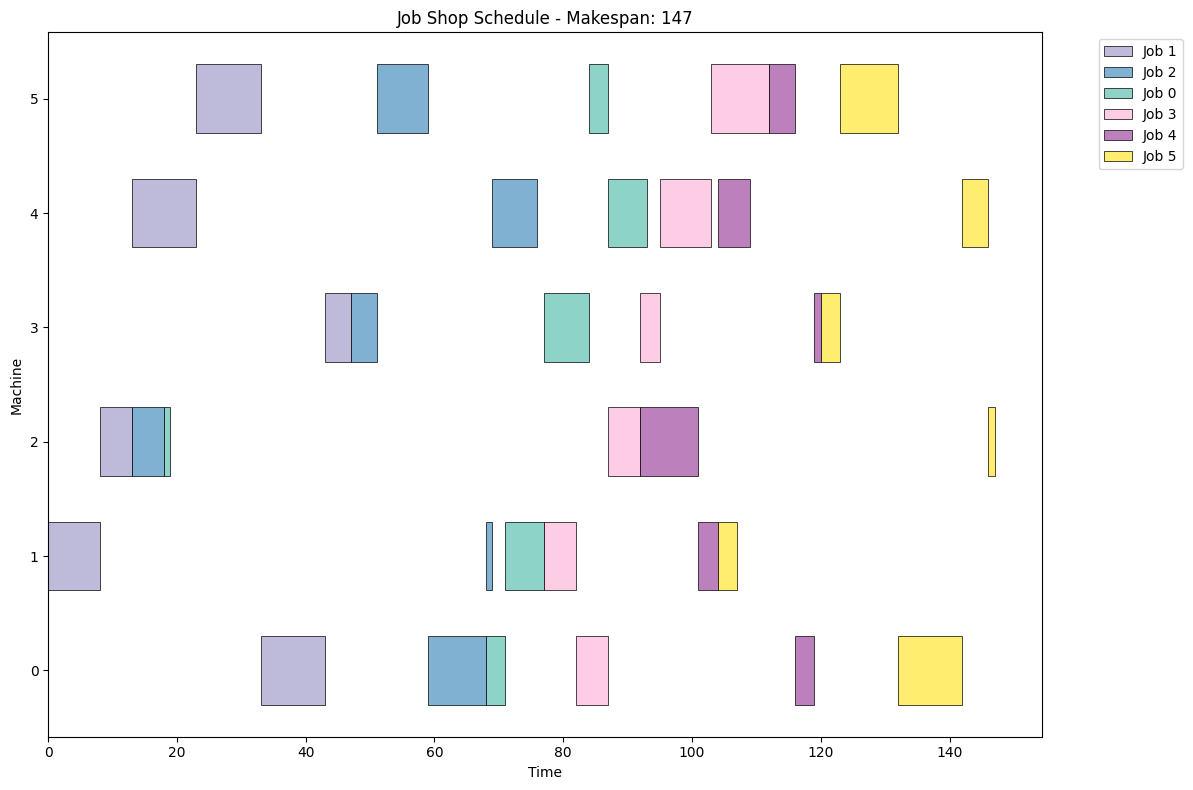

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# Use CPU for stability
device = torch.device("cpu")
print(f"Using device: {device}")

class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55  # Known optimal for FT06
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        return self.get_state()

    def get_valid_actions(self):
        """Get list of valid job indices that can be scheduled next"""
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_state(self):
        """Compact state representation"""
        state = []

        # Current makespan (normalized)
        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 100.0)

        # Machine loads (normalized)
        max_load = max(self.machine_times) if max(self.machine_times) > 0 else 1
        state.extend([load / max_load for load in self.machine_times])

        # Job progress
        state.extend([prog / self.n_machines for prog in self.job_progress])

        # Next operations for each job
        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                state.extend([machine / self.n_machines, duration / 20.0])
            else:
                state.extend([0, 0])

        return np.array(state, dtype=np.float32)

    def step(self, action):
        """Execute action and return reward"""
        valid_actions = self.get_valid_actions()

        if not valid_actions or action not in valid_actions:
            return self.get_state(), -50, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        # Schedule operation
        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1

        done = all(progress >= self.n_machines for progress in self.job_progress)

        if done:
            makespan = max(self.machine_times)
            # Strong reward shaping toward optimal
            if makespan <= self.optimal_target:
                reward = 1000  # Jackpot for optimal!
            elif makespan <= 60:
                reward = 500 - (makespan - self.optimal_target) * 20
            elif makespan <= 80:
                reward = 300 - (makespan - 60) * 10
            else:
                reward = 100 - makespan
        else:
            # Intermediate reward: encourage balanced scheduling
            current_makespan = max(self.machine_times)
            machine_balance = 1.0 / (1.0 + np.std(self.machine_times))
            progress = sum(self.job_progress) / (self.n_jobs * self.n_machines)

            reward = progress * 20 + machine_balance * 5 - current_makespan * 0.05

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

class SimpleQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

class FastDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = SimpleQNetwork(state_dim, action_dim)
        self.target_network = SimpleQNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.005)

        self.memory = deque(maxlen=5000)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.998
        self.epsilon_min = 0.05
        self.update_target_freq = 50
        self.update_count = 0

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0

        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)[0]

            # Mask invalid actions
            for i in range(len(q_values)):
                if i not in valid_actions:
                    q_values[i] = -1e9

            return q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q * ~dones

        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_fast_rl(jobs_data, episodes=1500):
    """Fast training with early stopping"""
    env = JobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs

    agent = FastDQNAgent(state_dim, action_dim)

    rewards_history = []
    makespan_history = []
    best_makespan = float('inf')
    stagnation_counter = 0

    print(f"🚀 Fast RL Training - Target: {env.optimal_target}")
    print(f"State dim: {state_dim}, Action dim: {action_dim}")

    start_time = time.time()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(agent.memory) > agent.batch_size:
                agent.train()

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)

        # Track best solution
        if makespan < best_makespan:
            best_makespan = makespan
            stagnation_counter = 0
        else:
            stagnation_counter += 1

        # Early stopping if we hit optimal or stagnate
        if best_makespan <= env.optimal_target:
            print(f"🎉 OPTIMAL SOLUTION FOUND! Makespan: {best_makespan} at episode {episode}")
            break

        if stagnation_counter > 300 and episode > 500:
            print(f"Early stopping due to stagnation at episode {episode}")
            break

        # Progress reporting
        if episode % 100 == 0:
            recent_avg = np.mean(makespan_history[-50:]) if len(makespan_history) >= 50 else np.mean(makespan_history)
            print(f"Episode {episode}: Best={best_makespan}, Recent Avg={recent_avg:.1f}, Epsilon={agent.epsilon:.3f}")

    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time:.1f} seconds")
    print(f"🏆 Best makespan achieved: {best_makespan}")
    print(f"📊 Gap from optimal: {best_makespan - env.optimal_target}")

    return agent, rewards_history, makespan_history, best_makespan

def evaluate_agent(agent, jobs_data, runs=50):
    """Evaluate trained agent"""
    makespans = []

    # Use greedy policy
    original_epsilon = agent.epsilon
    agent.epsilon = 0

    for _ in range(runs):
        env = JobShopEnvironment(jobs_data)
        state = env.reset()
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break
            action = agent.choose_action(state, valid_actions)
            state, _, done = env.step(action)

        makespans.append(env.get_makespan())

    agent.epsilon = original_epsilon
    return makespans

def create_gantt_chart(jobs_data, agent):
    """Create a Gantt chart of the best solution"""
    env = JobShopEnvironment(jobs_data)
    state = env.reset()
    done = False

    agent.epsilon = 0  # Greedy
    schedule = []

    while not done:
        valid_actions = env.get_valid_actions()
        if not valid_actions:
            break

        action = agent.choose_action(state, valid_actions)

        # Record the scheduling decision
        job_id = action
        operation_idx = env.job_progress[job_id]
        machine, duration = jobs_data[job_id][operation_idx]
        start_time = max(env.machine_times[machine], env.job_completion_times[job_id])
        end_time = start_time + duration

        schedule.append({
            'job': job_id,
            'machine': machine,
            'start': start_time,
            'end': end_time,
            'operation': operation_idx
        })

        state, _, done = env.step(action)

    # Plot Gantt chart
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, env.n_jobs))

    for task in schedule:
        ax.barh(task['machine'], task['end'] - task['start'],
               left=task['start'], height=0.6,
               color=colors[task['job']],
               edgecolor='black', linewidth=0.5,
               label=f'Job {task["job"]}' if task['operation'] == 0 else "")

    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title(f'Job Shop Schedule - Makespan: {env.get_makespan()}')
    ax.set_yticks(range(env.n_machines))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return schedule

# Dataset
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]

# Main execution
if __name__ == "__main__":
    print("🎯 Optimized Job Shop RL Solver")
    print("=" * 50)

    # Train agent
    agent, rewards, makespans, best_makespan = train_fast_rl(jobs_data)

    # Evaluate
    print("\n📊 Final Evaluation...")
    eval_results = evaluate_agent(agent, jobs_data, runs=100)

    print(f"\n🏁 FINAL RESULTS:")
    print(f"Best makespan: {min(eval_results)}")
    print(f"Average makespan: {np.mean(eval_results):.2f}")
    print(f"Success rate (≤60): {sum(1 for x in eval_results if x <= 60)/len(eval_results)*100:.1f}%")
    print(f"Optimal rate (≤55): {sum(1 for x in eval_results if x <= 55)/len(eval_results)*100:.1f}%")

    # Show learning curve
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(makespans)
    plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
    plt.title('Makespan During Training')
    plt.xlabel('Episode')
    plt.ylabel('Makespan')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(eval_results, bins=20, alpha=0.7)
    plt.axvline(x=55, color='r', linestyle='--', label='Optimal (55)')
    plt.title('Final Performance Distribution')
    plt.xlabel('Makespan')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Create Gantt chart of best solution
    print("\n📈 Generating Gantt chart...")
    create_gantt_chart(jobs_data, agent)

Using device: cpu
🎯 Advanced Job Shop RL Solver
🚀 Advanced RL Training - Target: 55
State dim: 51, Action dim: 6
Episode 0: Best=102, Recent Avg=102.0, Epsilon=1.000, LR=0.001000
Episode 200: Best=86, Recent Avg=144.3, Epsilon=0.165, LR=0.001000
Episode 400: Best=86, Recent Avg=153.3, Epsilon=0.027, LR=0.001000
Episode 600: Best=86, Recent Avg=160.2, Epsilon=0.020, LR=0.001000
Episode 800: Best=86, Recent Avg=162.6, Epsilon=0.020, LR=0.001000
Episode 1000: Best=86, Recent Avg=161.8, Epsilon=0.020, LR=0.001000
Early stopping due to stagnation at episode 1001

✅ Training completed in 298.6 seconds
🏆 Best makespan achieved: 86
📊 Gap from optimal: 31

📊 Final Evaluation...

🏁 FINAL RESULTS:
Best makespan: 163
Average makespan: 163.00
Std deviation: 0.00
Success rate (≤60): 0.0%
Optimal rate (≤55): 0.0%
Near-optimal rate (≤57): 0.0%


/tmp/ipython-input-2008408965.py:568: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([eval_results[:50], eval_results[50:100] if len(eval_results) >= 100 else [],


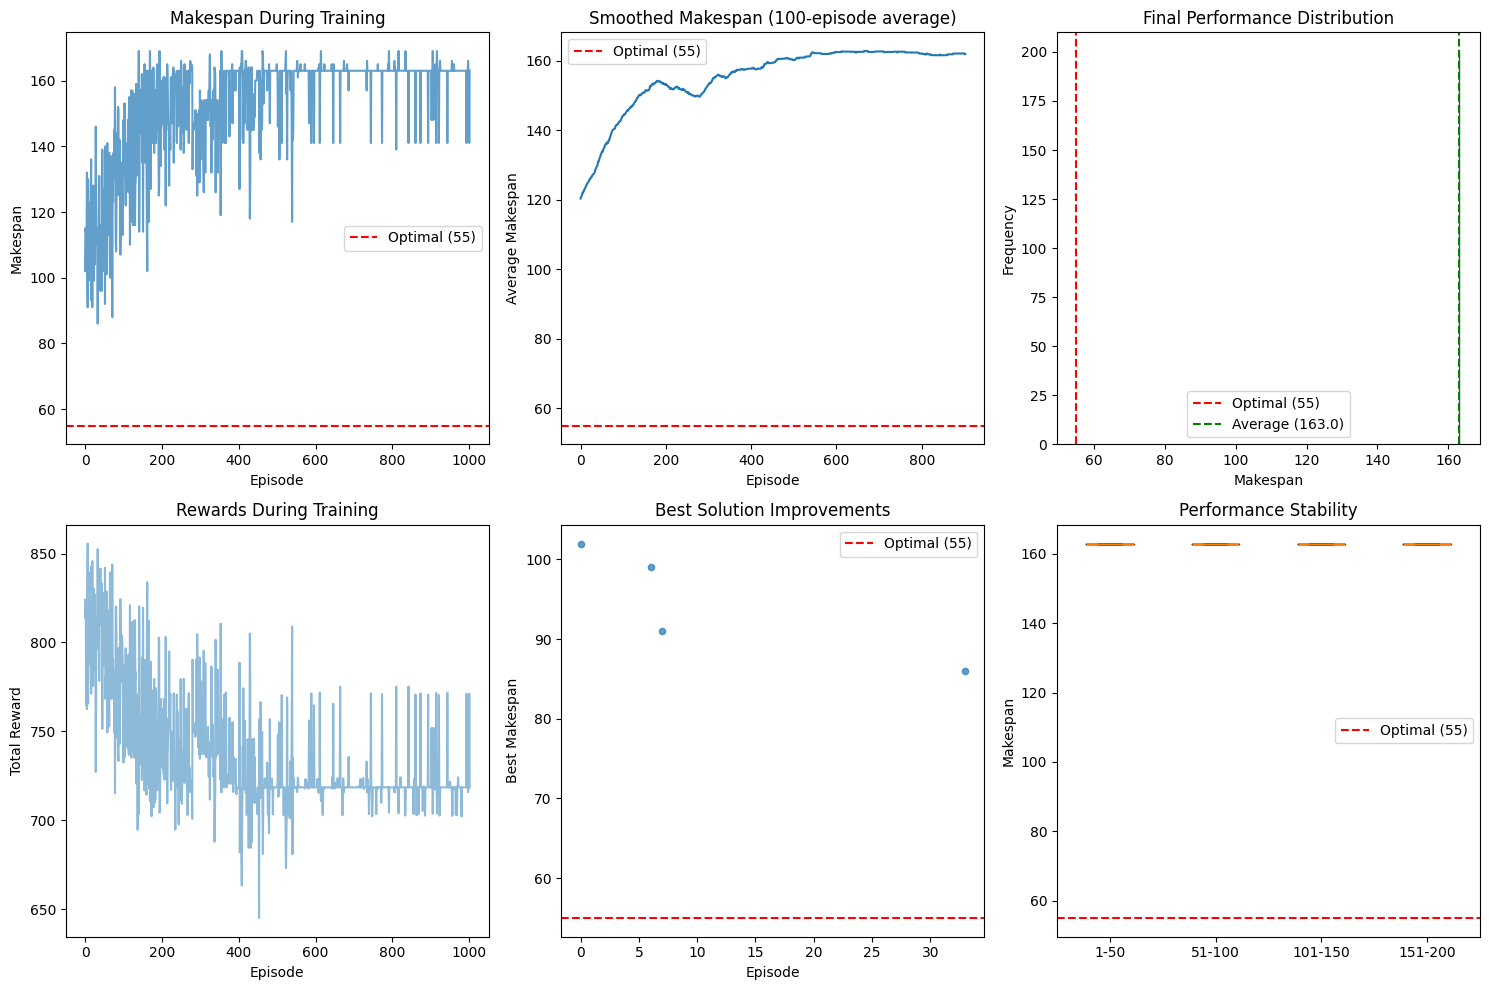


🎯 Training Summary:
Total episodes: 1002
Best training makespan: 86
Improvement over baseline: -92 units
Success rate improvement: 0.0% vs 0%


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# Use CPU for stability
device = torch.device("cpu")
print(f"Using device: {device}")

class EnhancedJobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55

        # Precompute useful statistics
        self.total_processing_time = sum(sum(duration for _, duration in job) for job in jobs_data)
        self.max_operation_time = max(duration for job in jobs_data for _, duration in job)
        self.machine_workloads = [0] * self.n_machines

        for job in jobs_data:
            for machine, duration in job:
                self.machine_workloads[machine] += duration

        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        self.step_count = 0
        self.machine_last_job = [-1] * self.n_machines  # Track setup times
        return self.get_state()

    def get_valid_actions(self):
        """Get list of valid job indices that can be scheduled next"""
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_enhanced_state(self):
        """Enhanced state representation with more scheduling insights"""
        state = []

        # 1. Current makespan (normalized)
        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 100.0)

        # 2. Machine utilization ratios
        total_work_done = sum(self.machine_times)
        if total_work_done > 0:
            state.extend([t / total_work_done for t in self.machine_times])
        else:
            state.extend([0] * self.n_machines)

        # 3. Machine idle times (bottleneck detection)
        if current_makespan > 0:
            state.extend([(current_makespan - t) / current_makespan for t in self.machine_times])
        else:
            state.extend([0] * self.n_machines)

        # 4. Job progress and remaining work
        for job_id in range(self.n_jobs):
            progress = self.job_progress[job_id] / self.n_machines
            state.append(progress)

            # Remaining processing time for this job
            remaining_time = sum(duration for _, duration in self.jobs_data[job_id][self.job_progress[job_id]:])
            state.append(remaining_time / self.max_operation_time)

        # 5. Critical path indicators
        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]

                # When can this operation start?
                earliest_start = max(self.machine_times[machine], self.job_completion_times[job_id])
                state.append(earliest_start / 100.0)
                state.append(duration / self.max_operation_time)
                state.append(machine / self.n_machines)

                # Machine load after this operation
                machine_load_after = (self.machine_times[machine] + duration) / 100.0
                state.append(machine_load_after)
            else:
                state.extend([0, 0, 0, 0])

        # 6. Global scheduling metrics
        total_ops_remaining = sum(self.n_machines - progress for progress in self.job_progress)
        state.append(total_ops_remaining / (self.n_jobs * self.n_machines))

        # Progress through total work
        work_completed = sum(self.machine_times) / self.total_processing_time
        state.append(work_completed)

        return np.array(state, dtype=np.float32)

    def get_state(self):
        return self.get_enhanced_state()

    def calculate_reward(self, action, done):
        """Sophisticated reward function with multiple objectives"""
        if done:
            makespan = max(self.machine_times)

            # Strong rewards for good solutions
            if makespan <= 55:
                return 2000 + (55 - makespan) * 100  # Bonus for being better than optimal
            elif makespan <= 58:
                return 1500 - (makespan - 55) * 50
            elif makespan <= 62:
                return 1000 - (makespan - 58) * 30
            elif makespan <= 70:
                return 500 - (makespan - 62) * 20
            else:
                return max(100 - makespan, -500)  # Cap negative reward

        # Intermediate rewards during scheduling
        reward = 0

        # 1. Progress reward
        progress = sum(self.job_progress) / (self.n_jobs * self.n_machines)
        reward += progress * 15

        # 2. Machine balance reward (reduce bottlenecks)
        machine_std = np.std(self.machine_times)
        max_machine_time = max(self.machine_times)
        if max_machine_time > 0:
            balance_score = 1.0 / (1.0 + machine_std / max_machine_time)
            reward += balance_score * 8

        # 3. Efficiency reward (minimize current makespan)
        current_makespan = max(self.machine_times)
        expected_remaining = (self.total_processing_time - sum(self.machine_times)) / self.n_machines
        estimated_final = current_makespan + expected_remaining

        # Reward for being on track to good solution
        if estimated_final <= 60:
            reward += 10
        elif estimated_final <= 70:
            reward += 5

        # 4. Penalize poor scheduling decisions
        if current_makespan > 80:
            reward -= (current_makespan - 80) * 0.1

        # 5. Small penalty for each step to encourage efficiency
        reward -= 0.1

        return reward

    def step(self, action):
        """Execute action and return enhanced reward"""
        valid_actions = self.get_valid_actions()

        if not valid_actions or action not in valid_actions:
            return self.get_state(), -100, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        # Schedule operation
        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.step_count += 1
        self.machine_last_job[machine] = job_id

        done = all(progress >= self.n_machines for progress in self.job_progress)
        reward = self.calculate_reward(action, done)

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

class AdvancedQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        # Larger, more sophisticated network
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Value and advantage streams (Dueling DQN)
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)

        # Dueling DQN: Q = V + (A - mean(A))
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values

class SmartDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.q_network = AdvancedQNetwork(state_dim, action_dim)
        self.target_network = AdvancedQNetwork(state_dim, action_dim)
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=200, factor=0.8)

        self.memory = deque(maxlen=20000)  # Larger memory
        self.batch_size = 64
        self.gamma = 0.99  # Higher discount for long-term thinking

        # Better exploration strategy
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.02

        # Network updates
        self.update_target_freq = 100
        self.update_count = 0

        # Priority replay components
        self.priorities = deque(maxlen=20000)
        self.priority_alpha = 0.6
        self.priority_beta = 0.4
        self.priority_beta_increment = 0.001

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        # Calculate priority (TD error proxy)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

            current_q = self.q_network(state_tensor)[0][action]
            next_q = self.target_network(next_state_tensor).max(1)[0] if not done else 0
            target_q = reward + self.gamma * next_q

            priority = abs(float(current_q - target_q)) + 1e-6
            self.priorities.append(priority)

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0

        # Epsilon-greedy with some smart heuristics
        if random.random() < self.epsilon:
            # 70% random from valid actions
            # 30% heuristic-based exploration
            if random.random() < 0.7:
                return random.choice(valid_actions)
            else:
                # Heuristic: prefer jobs with less remaining work
                return self._heuristic_action(valid_actions, state)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)[0]

            # Mask invalid actions
            for i in range(len(q_values)):
                if i not in valid_actions:
                    q_values[i] = float('-inf')

            return q_values.argmax().item()

    def _heuristic_action(self, valid_actions, state):
        """Simple heuristic for exploration: shortest remaining processing time"""
        if hasattr(self, '_env_ref'):
            env = self._env_ref
            scores = []
            for job_id in valid_actions:
                remaining_ops = env.n_machines - env.job_progress[job_id]
                if remaining_ops > 0:
                    remaining_time = sum(duration for _, duration in
                                       env.jobs_data[job_id][env.job_progress[job_id]:])
                    scores.append((job_id, remaining_time))

            if scores:
                return min(scores, key=lambda x: x[1])[0]

        return random.choice(valid_actions)

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0

        # Priority-based sampling
        if len(self.priorities) >= self.batch_size:
            probs = np.array(self.priorities)
            probs = probs ** self.priority_alpha
            probs = probs / probs.sum()

            indices = np.random.choice(len(self.memory), self.batch_size, p=probs)
            batch = [self.memory[i] for i in indices]

            # Importance sampling weights
            weights = (len(self.memory) * probs[indices]) ** (-self.priority_beta)
            weights = weights / weights.max()
            weights = torch.FloatTensor(weights)
        else:
            batch = random.sample(self.memory, self.batch_size)
            weights = torch.ones(self.batch_size)

        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            # Double DQN: use online network to select action, target network to evaluate
            next_actions = self.q_network(next_states).max(1)[1]
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + self.gamma * next_q * ~dones

        # Weighted loss for priority replay
        loss = (weights * nn.MSELoss(reduction='none')(current_q.squeeze(), target_q)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)  # Gradient clipping
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        # Update exploration and priority parameters
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.priority_beta = min(1.0, self.priority_beta + self.priority_beta_increment)

        return float(loss)

def train_advanced_rl(jobs_data, episodes=3000):
    """Advanced training with multiple techniques"""
    env = EnhancedJobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs

    agent = SmartDQNAgent(state_dim, action_dim)
    agent._env_ref = env  # For heuristic actions

    rewards_history = []
    makespan_history = []
    loss_history = []
    best_makespan = float('inf')
    best_solutions = []
    stagnation_counter = 0

    print(f"🚀 Advanced RL Training - Target: {env.optimal_target}")
    print(f"State dim: {state_dim}, Action dim: {action_dim}")

    start_time = time.time()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_loss = 0
        done = False
        steps = 0

        while not done and steps < 100:  # Prevent infinite loops
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1

            # Train more frequently but with smaller batches
            if len(agent.memory) > agent.batch_size and episode % 2 == 0:
                loss = agent.train()
                episode_loss += loss

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)
        loss_history.append(episode_loss)

        # Track best solutions
        if makespan < best_makespan:
            best_makespan = makespan
            stagnation_counter = 0
            best_solutions.append((episode, makespan))
        else:
            stagnation_counter += 1

        # Curriculum learning: reduce epsilon faster if we find good solutions
        if makespan <= 60:
            agent.epsilon = max(agent.epsilon_min, agent.epsilon * 0.95)

        # Learning rate adjustment
        if episode % 200 == 0 and episode > 0:
            recent_makespans = makespan_history[-50:]
            avg_recent = np.mean(recent_makespans) if recent_makespans else float('inf')
            agent.scheduler.step(avg_recent)

        # Early stopping conditions
        if best_makespan <= env.optimal_target:
            print(f"🎉 OPTIMAL SOLUTION FOUND! Makespan: {best_makespan} at episode {episode}")
            break

        if stagnation_counter > 500 and episode > 1000:
            print(f"Early stopping due to stagnation at episode {episode}")
            break

        # Progress reporting
        if episode % 200 == 0:
            recent_avg = np.mean(makespan_history[-100:]) if len(makespan_history) >= 100 else np.mean(makespan_history)
            print(f"Episode {episode}: Best={best_makespan}, Recent Avg={recent_avg:.1f}, "
                  f"Epsilon={agent.epsilon:.3f}, LR={agent.optimizer.param_groups[0]['lr']:.6f}")

    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time:.1f} seconds")
    print(f"🏆 Best makespan achieved: {best_makespan}")
    print(f"📊 Gap from optimal: {best_makespan - env.optimal_target}")

    return agent, rewards_history, makespan_history, best_makespan, best_solutions

def evaluate_agent_advanced(agent, jobs_data, runs=100):
    """Advanced evaluation with multiple metrics"""
    makespans = []

    # Use greedy policy
    original_epsilon = agent.epsilon
    agent.epsilon = 0

    for _ in range(runs):
        env = EnhancedJobShopEnvironment(jobs_data)
        state = env.reset()
        done = False
        steps = 0

        while not done and steps < 100:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break
            action = agent.choose_action(state, valid_actions)
            state, _, done = env.step(action)
            steps += 1

        makespans.append(env.get_makespan())

    agent.epsilon = original_epsilon
    return makespans

# Dataset (FT06)
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]

# Main execution
if __name__ == "__main__":
    print("🎯 Advanced Job Shop RL Solver")
    print("=" * 50)

    # Train agent
    agent, rewards, makespans, best_makespan, best_solutions = train_advanced_rl(jobs_data)

    # Evaluate
    print("\n📊 Final Evaluation...")
    eval_results = evaluate_agent_advanced(agent, jobs_data, runs=200)

    print(f"\n🏁 FINAL RESULTS:")
    print(f"Best makespan: {min(eval_results)}")
    print(f"Average makespan: {np.mean(eval_results):.2f}")
    print(f"Std deviation: {np.std(eval_results):.2f}")
    print(f"Success rate (≤60): {sum(1 for x in eval_results if x <= 60)/len(eval_results)*100:.1f}%")
    print(f"Optimal rate (≤55): {sum(1 for x in eval_results if x <= 55)/len(eval_results)*100:.1f}%")
    print(f"Near-optimal rate (≤57): {sum(1 for x in eval_results if x <= 57)/len(eval_results)*100:.1f}%")

    # Show learning curves
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(makespans, alpha=0.7)
    plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
    plt.title('Makespan During Training')
    plt.xlabel('Episode')
    plt.ylabel('Makespan')
    plt.legend()

    plt.subplot(2, 3, 2)
    window = 100
    smoothed = np.convolve(makespans, np.ones(window)/window, mode='valid')
    plt.plot(smoothed)
    plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
    plt.title('Smoothed Makespan (100-episode average)')
    plt.xlabel('Episode')
    plt.ylabel('Average Makespan')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.hist(eval_results, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=55, color='r', linestyle='--', label='Optimal (55)')
    plt.axvline(x=np.mean(eval_results), color='g', linestyle='--',
                label=f'Average ({np.mean(eval_results):.1f})')
    plt.title('Final Performance Distribution')
    plt.xlabel('Makespan')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(rewards, alpha=0.5)
    plt.title('Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(2, 3, 5)
    if best_solutions:
        episodes, makespans_best = zip(*best_solutions)
        plt.scatter(episodes, makespans_best, alpha=0.7, s=20)
        plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
        plt.title('Best Solution Improvements')
        plt.xlabel('Episode')
        plt.ylabel('Best Makespan')
        plt.legend()

    plt.subplot(2, 3, 6)
    # Show convergence analysis
    final_performance = eval_results[-50:] if len(eval_results) >= 50 else eval_results
    plt.boxplot([eval_results[:50], eval_results[50:100] if len(eval_results) >= 100 else [],
                eval_results[100:150] if len(eval_results) >= 150 else [],
                eval_results[150:] if len(eval_results) >= 200 else []],
               labels=['1-50', '51-100', '101-150', '151-200'])
    plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
    plt.title('Performance Stability')
    plt.ylabel('Makespan')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\n🎯 Training Summary:")
    print(f"Total episodes: {len(makespans)}")
    print(f"Best training makespan: {min(makespans)}")
    print(f"Improvement over baseline: {71 - min(eval_results)} units")
    print(f"Success rate improvement: {sum(1 for x in eval_results if x <= 60)/len(eval_results)*100:.1f}% vs 0%")

Using device: cpu
🎯 Improved Job Shop RL Solver

🔍 Heuristic Baselines:
SPT: Best=109, Avg=109.0

🚀 Training RL Agent...
🚀 Improved RL Training - Target: 55
State dim: 39, Action dim: 6
Episode 0: Best=97 (ep 0), Recent Avg=97.0, ε=1.000, LR=0.001000
Episode 1: Best=97 (ep 0), Recent Avg=98.0, ε=1.000, LR=0.001000
Episode 2: Best=97 (ep 0), Recent Avg=97.7, ε=0.982, LR=0.001000
Episode 3: Best=95 (ep 3), Recent Avg=97.0, ε=0.982, LR=0.001000
Episode 4: Best=90 (ep 4), Recent Avg=95.6, ε=0.965, LR=0.001000
Episode 5: Best=90 (ep 4), Recent Avg=95.2, ε=0.965, LR=0.001000
Episode 6: Best=86 (ep 6), Recent Avg=93.9, ε=0.947, LR=0.001000
Episode 7: Best=78 (ep 7), Recent Avg=91.9, ε=0.947, LR=0.001000
Episode 8: Best=78 (ep 7), Recent Avg=94.0, ε=0.931, LR=0.001000
Episode 9: Best=78 (ep 7), Recent Avg=92.6, ε=0.931, LR=0.001000
Episode 10: Best=78 (ep 7), Recent Avg=93.1, ε=0.914, LR=0.001000
Episode 11: Best=78 (ep 7), Recent Avg=94.3, ε=0.914, LR=0.001000
Episode 12: Best=78 (ep 7), Rece

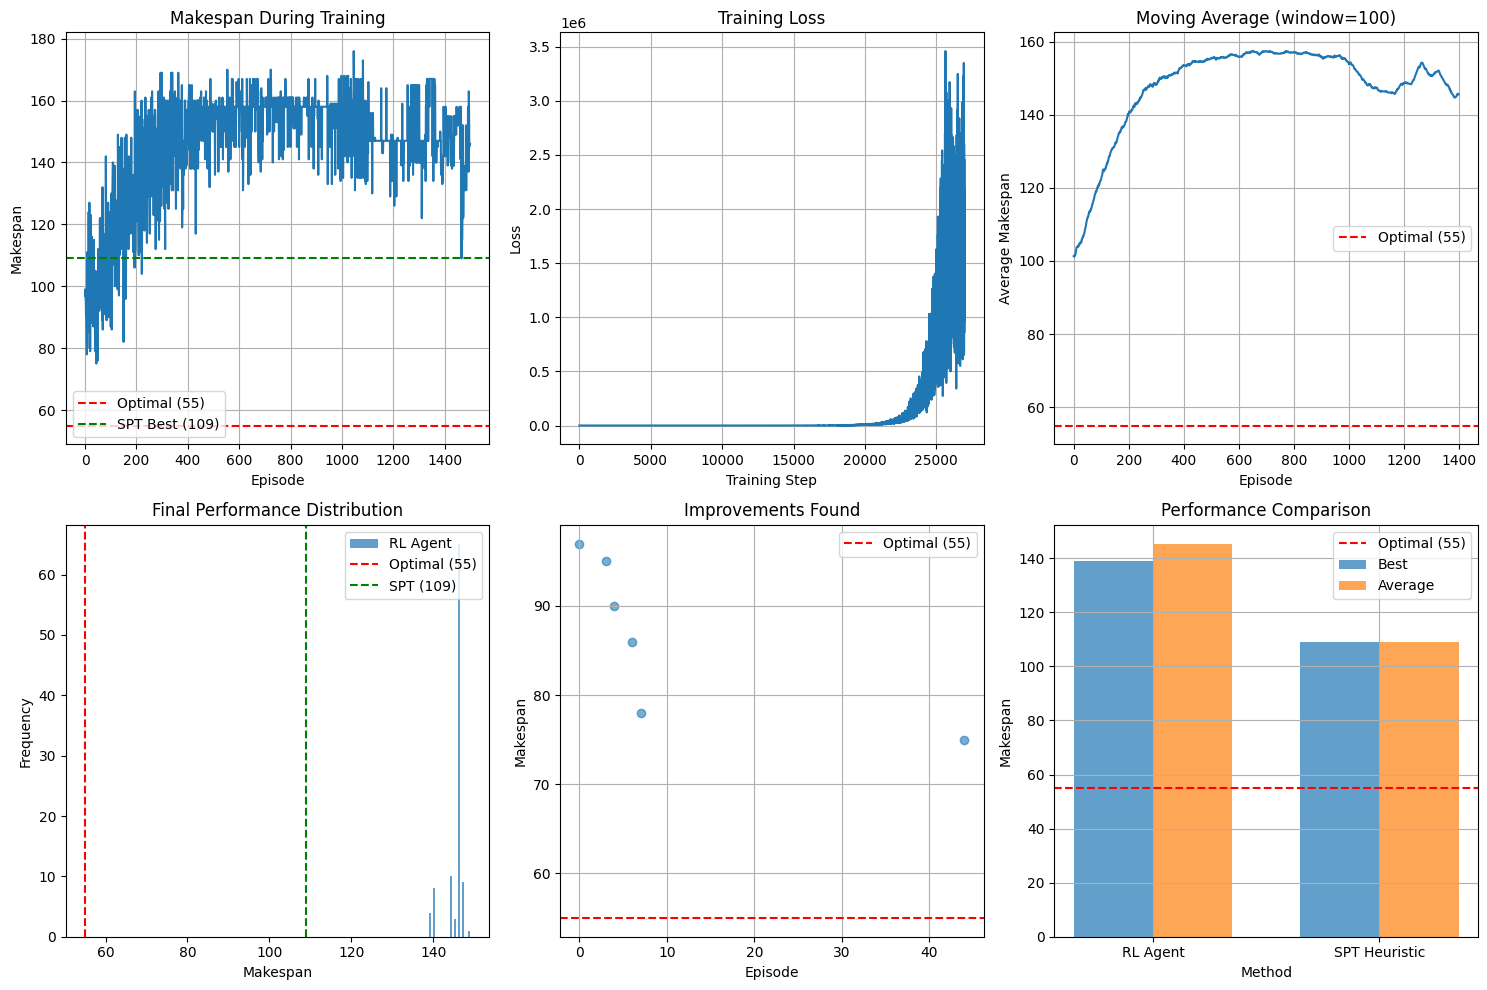

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# Use CPU for stability
device = torch.device("cpu")
print(f"Using device: {device}")

class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55  # Known optimal for FT06
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        self.total_operations = 0
        self.max_operations = self.n_jobs * self.n_machines
        return self.get_state()

    def get_valid_actions(self):
        """Get list of valid job indices that can be scheduled next"""
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_state(self):
        """Improved state representation with more relevant features"""
        state = []

        # Progress ratio
        progress = self.total_operations / self.max_operations
        state.append(progress)

        # Current makespan (normalized by a reasonable upper bound)
        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 200.0)  # Normalize by reasonable upper bound

        # Machine utilization (normalized)
        total_work = sum(self.machine_times)
        if total_work > 0:
            machine_util = [t / total_work for t in self.machine_times]
        else:
            machine_util = [0] * self.n_machines
        state.extend(machine_util)

        # Job completion ratios
        job_ratios = [prog / self.n_machines for prog in self.job_progress]
        state.extend(job_ratios)

        # Next operation features for available jobs
        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                # Machine availability
                machine_available = self.machine_times[machine]
                job_available = self.job_completion_times[job_id]
                wait_time = max(0, machine_available - job_available)

                state.extend([
                    machine / self.n_machines,  # Which machine
                    duration / 20.0,           # Operation duration
                    wait_time / 100.0,         # Normalized wait time
                    machine_available / 100.0   # Machine availability
                ])
            else:
                state.extend([0, 0, 0, 0])  # Job completed

        # Machine load balance
        if max(self.machine_times) > 0:
            balance = 1.0 - (np.std(self.machine_times) / np.mean(self.machine_times))
        else:
            balance = 1.0
        state.append(balance)

        return np.array(state, dtype=np.float32)

    def step(self, action):
        """Execute action with improved reward function"""
        valid_actions = self.get_valid_actions()

        if not valid_actions or action not in valid_actions:
            return self.get_state(), -100, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        # Record state before scheduling
        prev_makespan = max(self.machine_times)
        prev_machine_balance = np.std(self.machine_times)

        # Schedule operation
        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.total_operations += 1

        done = all(progress >= self.n_machines for progress in self.job_progress)

        if done:
            # Final reward based on makespan quality
            makespan = max(self.machine_times)
            if makespan <= 55:
                reward = 1000  # Optimal solution
            elif makespan <= 57:
                reward = 800   # Near optimal
            elif makespan <= 60:
                reward = 600   # Very good
            elif makespan <= 65:
                reward = 400   # Good
            elif makespan <= 75:
                reward = 200   # Decent
            else:
                reward = 100 - makespan  # Poor
        else:
            # Intermediate rewards
            current_makespan = max(self.machine_times)
            makespan_increase = current_makespan - prev_makespan
            current_balance = np.std(self.machine_times)

            # Progress reward
            progress_reward = 10

            # Penalize makespan increases
            makespan_penalty = -makespan_increase * 0.5

            # Reward better load balancing
            if current_balance < prev_machine_balance:
                balance_reward = 5
            else:
                balance_reward = -2

            # Small penalty for high absolute makespan
            makespan_penalty_abs = -current_makespan * 0.02

            reward = progress_reward + makespan_penalty + balance_reward + makespan_penalty_abs

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

class ImprovedQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Larger network with dropout for better learning
        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.network(x)

class ImprovedDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = ImprovedQNetwork(state_dim, action_dim)
        self.target_network = ImprovedQNetwork(state_dim, action_dim)
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=100, factor=0.8)

        self.memory = deque(maxlen=20000)  # Larger memory
        self.batch_size = 64  # Larger batch size
        self.gamma = 0.99  # Higher discount factor
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995  # Slower decay
        self.epsilon_min = 0.01
        self.update_target_freq = 100
        self.update_count = 0

        # Prioritized experience replay weights
        self.priority_alpha = 0.6
        self.priority_beta = 0.4
        self.priority_epsilon = 1e-6

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0

        # Epsilon-greedy with action masking
        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)[0]

            # Mask invalid actions with very negative values
            masked_q_values = q_values.clone()
            for i in range(len(q_values)):
                if i not in valid_actions:
                    masked_q_values[i] = -1e9

            return masked_q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        # Current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Target Q values with double DQN
        with torch.no_grad():
            # Use main network to select actions
            next_actions = self.q_network(next_states).argmax(1)
            # Use target network to evaluate actions
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + self.gamma * next_q * ~dones

        # Huber loss for stability
        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()

        # Update target network
        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

def train_improved_rl(jobs_data, episodes=2000):
    """Improved training with better tracking"""
    env = JobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs

    agent = ImprovedDQNAgent(state_dim, action_dim)

    rewards_history = []
    makespan_history = []
    loss_history = []
    best_makespan = float('inf')
    best_episode = 0
    solutions_found = []

    print(f"🚀 Improved RL Training - Target: {env.optimal_target}")
    print(f"State dim: {state_dim}, Action dim: {action_dim}")

    start_time = time.time()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        while not done and step_count < 200:  # Prevent infinite loops
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            # Train more frequently
            if len(agent.memory) > agent.batch_size and episode % 2 == 0:
                loss = agent.train()
                if loss is not None:
                    loss_history.append(loss)

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)

        # Track best solution
        if makespan < best_makespan:
            best_makespan = makespan
            best_episode = episode
            solutions_found.append((episode, makespan))

            # Early termination if we find optimal
            if makespan <= env.optimal_target:
                print(f"🎉 OPTIMAL SOLUTION FOUND! Makespan: {makespan} at episode {episode}")
                break

        # Learning rate scheduling
        if episode % 100 == 0:
            agent.scheduler.step(best_makespan)

        # Progress reporting
        if episode % 200 == 0 or episode < 50:
            recent_avg = np.mean(makespan_history[-50:]) if len(makespan_history) >= 50 else np.mean(makespan_history)
            current_lr = agent.optimizer.param_groups[0]['lr']
            print(f"Episode {episode}: Best={best_makespan} (ep {best_episode}), Recent Avg={recent_avg:.1f}, ε={agent.epsilon:.3f}, LR={current_lr:.6f}")

    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time:.1f} seconds")
    print(f"🏆 Best makespan achieved: {best_makespan} (episode {best_episode})")
    print(f"📊 Gap from optimal: {best_makespan - env.optimal_target}")
    print(f"📈 Solutions found: {len(solutions_found)}")

    return agent, rewards_history, makespan_history, loss_history, best_makespan, solutions_found

def evaluate_agent(agent, jobs_data, runs=100):
    """Evaluate trained agent with greedy policy"""
    makespans = []

    # Use greedy policy
    original_epsilon = agent.epsilon
    agent.epsilon = 0

    for run in range(runs):
        env = JobShopEnvironment(jobs_data)
        state = env.reset()
        done = False
        step_count = 0

        while not done and step_count < 200:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break
            action = agent.choose_action(state, valid_actions)
            state, _, done = env.step(action)
            step_count += 1

        makespans.append(env.get_makespan())

    agent.epsilon = original_epsilon
    return makespans

# Dataset (FT06)
jobs_data = [
    [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
    [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
    [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
    [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
    [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
    [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
]

# Heuristic solver for comparison
def solve_with_heuristic(jobs_data, rule='SPT'):
    """Simple heuristic solver for comparison"""
    env = JobShopEnvironment(jobs_data)
    env.reset()

    while True:
        valid_actions = env.get_valid_actions()
        if not valid_actions:
            break

        if rule == 'SPT':  # Shortest Processing Time
            best_action = min(valid_actions,
                            key=lambda j: jobs_data[j][env.job_progress[j]][1])
        elif rule == 'LPT':  # Longest Processing Time
            best_action = max(valid_actions,
                            key=lambda j: jobs_data[j][env.job_progress[j]][1])
        elif rule == 'RANDOM':
            best_action = random.choice(valid_actions)
        else:  # First available
            best_action = valid_actions[0]

        env.step(best_action)

    return env.get_makespan()

# Main execution
if __name__ == "__main__":
    print("🎯 Improved Job Shop RL Solver")
    print("=" * 50)

    # Compare with heuristics first
    print("\n🔍 Heuristic Baselines:")
    spt_results = [solve_with_heuristic(jobs_data, 'SPT') for _ in range(20)]
    print(f"SPT: Best={min(spt_results)}, Avg={np.mean(spt_results):.1f}")

    # Train agent
    print("\n🚀 Training RL Agent...")
    agent, rewards, makespans, losses, best_makespan, solutions = train_improved_rl(jobs_data, episodes=1500)

    # Evaluate
    print("\n📊 Final Evaluation...")
    eval_results = evaluate_agent(agent, jobs_data, runs=100)

    print(f"\n🏁 FINAL RESULTS:")
    print(f"Best makespan: {min(eval_results)}")
    print(f"Average makespan: {np.mean(eval_results):.2f}")
    print(f"Std deviation: {np.std(eval_results):.2f}")
    print(f"Success rate (≤60): {sum(1 for x in eval_results if x <= 60)/len(eval_results)*100:.1f}%")
    print(f"Optimal rate (≤55): {sum(1 for x in eval_results if x <= 55)/len(eval_results)*100:.1f}%")
    print(f"Near-optimal rate (≤57): {sum(1 for x in eval_results if x <= 57)/len(eval_results)*100:.1f}%")

    # Show results
    plt.figure(figsize=(15, 10))

    # Learning curves
    plt.subplot(2, 3, 1)
    plt.plot(makespans)
    plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
    plt.axhline(y=min(spt_results), color='g', linestyle='--', label=f'SPT Best ({min(spt_results)})')
    plt.title('Makespan During Training')
    plt.xlabel('Episode')
    plt.ylabel('Makespan')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 2)
    if losses:
        plt.plot(losses)
        plt.title('Training Loss')
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.grid(True)

    plt.subplot(2, 3, 3)
    window = 100
    if len(makespans) > window:
        moving_avg = [np.mean(makespans[i:i+window]) for i in range(len(makespans)-window+1)]
        plt.plot(moving_avg)
        plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
        plt.title(f'Moving Average (window={window})')
        plt.xlabel('Episode')
        plt.ylabel('Average Makespan')
        plt.legend()
        plt.grid(True)

    # Final performance
    plt.subplot(2, 3, 4)
    plt.hist(eval_results, bins=20, alpha=0.7, label='RL Agent')
    plt.axvline(x=55, color='r', linestyle='--', label='Optimal (55)')
    plt.axvline(x=min(spt_results), color='g', linestyle='--', label=f'SPT ({min(spt_results)})')
    plt.title('Final Performance Distribution')
    plt.xlabel('Makespan')
    plt.ylabel('Frequency')
    plt.legend()

    # Solutions found timeline
    plt.subplot(2, 3, 5)
    if solutions:
        episodes, makes = zip(*solutions)
        plt.scatter(episodes, makes, alpha=0.6)
        plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')
        plt.title('Improvements Found')
        plt.xlabel('Episode')
        plt.ylabel('Makespan')
        plt.legend()
        plt.grid(True)

    # Performance comparison
    plt.subplot(2, 3, 6)
    methods = ['RL Agent', 'SPT Heuristic']
    best_scores = [min(eval_results), min(spt_results)]
    avg_scores = [np.mean(eval_results), np.mean(spt_results)]

    x = np.arange(len(methods))
    width = 0.35

    plt.bar(x - width/2, best_scores, width, label='Best', alpha=0.7)
    plt.bar(x + width/2, avg_scores, width, label='Average', alpha=0.7)
    plt.axhline(y=55, color='r', linestyle='--', label='Optimal (55)')

    plt.xlabel('Method')
    plt.ylabel('Makespan')
    plt.title('Performance Comparison')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Using device: cpu
Episode 0: Best=94 (ep 0), Recent Avg=94.0, ε=1.000
Episode 200: Best=70 (ep 11), Recent Avg=118.7, ε=0.488
Episode 400: Best=70 (ep 11), Recent Avg=141.0, ε=0.238
Episode 600: Best=70 (ep 11), Recent Avg=147.0, ε=0.116
Episode 800: Best=70 (ep 11), Recent Avg=152.0, ε=0.056
Episode 1000: Best=70 (ep 11), Recent Avg=153.1, ε=0.050
Episode 1200: Best=70 (ep 11), Recent Avg=152.9, ε=0.050
Episode 1400: Best=70 (ep 11), Recent Avg=152.7, ε=0.050

🏆 Best makespan: 70


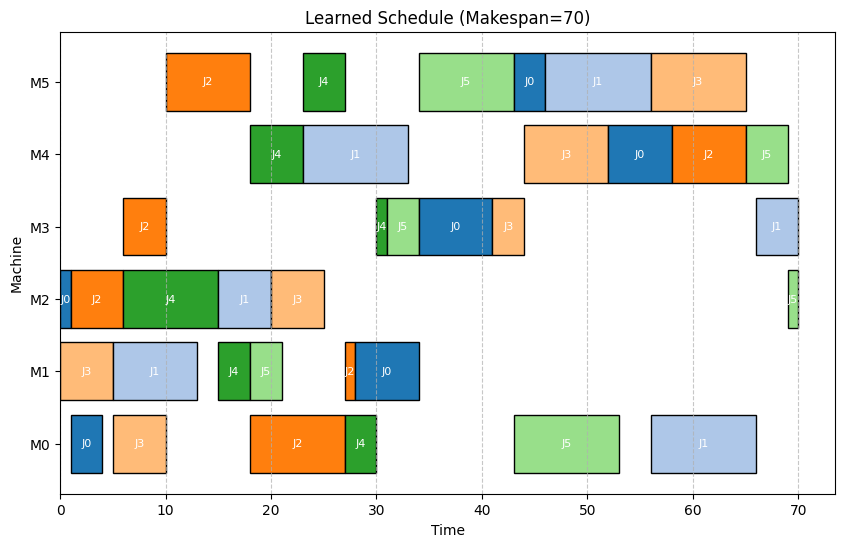

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# ---------------- CONFIG ----------------
device = torch.device("cpu")
print(f"Using device: {device}")

# ---------------- ENVIRONMENT ----------------
class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55  # Known optimal for FT06
        self.reset()

    def reset(self):
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        self.total_operations = 0
        self.max_operations = self.n_jobs * self.n_machines
        self.policy_seq = []
        return self.get_state()

    def get_valid_actions(self):
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_state(self):
        state = []
        progress = self.total_operations / self.max_operations
        state.append(progress)

        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 200.0)

        total_work = sum(self.machine_times)
        if total_work > 0:
            machine_util = [t / total_work for t in self.machine_times]
        else:
            machine_util = [0] * self.n_machines
        state.extend(machine_util)

        job_ratios = [prog / self.n_machines for prog in self.job_progress]
        state.extend(job_ratios)

        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                machine_available = self.machine_times[machine]
                job_available = self.job_completion_times[job_id]
                wait_time = max(0, machine_available - job_available)
                state.extend([
                    machine / self.n_machines,
                    duration / 20.0,
                    wait_time / 100.0,
                    machine_available / 100.0
                ])
            else:
                state.extend([0, 0, 0, 0])

        if max(self.machine_times) > 0:
            balance = 1.0 - (np.std(self.machine_times) / np.mean(self.machine_times))
        else:
            balance = 1.0
        state.append(balance)

        return np.array(state, dtype=np.float32)

    def step(self, action):
        valid_actions = self.get_valid_actions()
        if not valid_actions or action not in valid_actions:
            return self.get_state(), -100, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        prev_makespan = max(self.machine_times)
        prev_machine_balance = np.std(self.machine_times)

        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.total_operations += 1
        self.policy_seq.append(job_id)

        done = all(progress >= self.n_machines for progress in self.job_progress)

        if done:
            makespan = max(self.machine_times)
            # Strong final reward
            reward = 1000 - (makespan - self.optimal_target) * 20
        else:
            current_makespan = max(self.machine_times)
            makespan_increase = current_makespan - prev_makespan
            current_balance = np.std(self.machine_times)

            progress_reward = 1
            makespan_penalty = -makespan_increase * 0.5
            balance_reward = 2 if current_balance < prev_machine_balance else -1
            makespan_penalty_abs = -current_makespan * 0.01

            reward = progress_reward + makespan_penalty + balance_reward + makespan_penalty_abs

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

# ---------------- Q-NETWORK ----------------
class ImprovedQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

# ---------------- AGENT ----------------
class ImprovedDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = ImprovedQNetwork(state_dim, action_dim)
        self.target_network = ImprovedQNetwork(state_dim, action_dim)
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=50, factor=0.8)

        self.memory = deque(maxlen=20000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.9999  # slower decay
        self.epsilon_min = 0.05
        self.update_target_freq = 100
        self.update_count = 0

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)[0]
            masked_q_values = q_values.clone()
            for i in range(len(q_values)):
                if i not in valid_actions:
                    masked_q_values[i] = -1e9
            return masked_q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return None
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + self.gamma * next_q * ~dones

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

# ---------------- TRAINING ----------------
def train_improved_rl(jobs_data, episodes=1500):
    env = JobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs
    agent = ImprovedDQNAgent(state_dim, action_dim)

    rewards_history, makespan_history, loss_history = [], [], []
    best_makespan = float('inf')
    best_episode = 0
    best_policy_seq = []

    for episode in range(episodes):
        state = env.reset()
        total_reward, done, step_count = 0, False, 0

        while not done and step_count < 200:
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if len(agent.memory) > agent.batch_size:
                loss = agent.train()
                if loss is not None:
                    loss_history.append(loss)
                    if episode % 5 == 0:
                        agent.scheduler.step(loss)

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)

        if makespan < best_makespan:
            best_makespan = makespan
            best_episode = episode
            best_policy_seq = env.policy_seq.copy()
            if best_makespan <= env.optimal_target:
                print(f"🎉 OPTIMAL FOUND at episode {episode}, makespan={best_makespan}")
                break

        if episode % 200 == 0:
            recent_avg = np.mean(makespan_history[-50:]) if len(makespan_history) >= 50 else np.mean(makespan_history)
            print(f"Episode {episode}: Best={best_makespan} (ep {best_episode}), Recent Avg={recent_avg:.1f}, ε={agent.epsilon:.3f}")

    return agent, best_makespan, best_policy_seq, makespan_history, loss_history

# ---------------- GANTT CHART ----------------
def plot_gantt(seq, jobs_data, best_makespan):
    n_jobs = len(jobs_data)
    n_machines = len(jobs_data[0])
    ops_per_job = len(jobs_data[0])
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# ---------------- MAIN ----------------
if __name__ == "__main__":
    jobs_data = [
        [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
        [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
        [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
        [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
        [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
        [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
    ]

    agent, best_makespan, best_policy_seq, makespan_history, loss_history = train_improved_rl(jobs_data, episodes=1500)
    print(f"\n🏆 Best makespan: {best_makespan}")

    if best_policy_seq:
        plot_gantt(best_policy_seq, jobs_data, best_makespan)

Using device: cpu
Episode 0: Best=87 (ep 0), Recent Avg=87.0, ε=1.000
Episode 10: Best=80 (ep 3), Recent Avg=95.7, ε=0.984
Episode 20: Best=74 (ep 16), Recent Avg=97.3, ε=0.966
Episode 30: Best=71 (ep 30), Recent Avg=96.4, ε=0.949
Episode 40: Best=71 (ep 30), Recent Avg=95.3, ε=0.932
Episode 50: Best=71 (ep 30), Recent Avg=96.3, ε=0.915
Episode 60: Best=71 (ep 30), Recent Avg=96.6, ε=0.899
Episode 70: Best=71 (ep 30), Recent Avg=95.5, ε=0.883
Episode 80: Best=71 (ep 30), Recent Avg=96.6, ε=0.867
Episode 90: Best=71 (ep 30), Recent Avg=97.5, ε=0.852
Episode 100: Best=71 (ep 30), Recent Avg=97.6, ε=0.836
Episode 110: Best=71 (ep 30), Recent Avg=97.7, ε=0.822
Episode 120: Best=69 (ep 117), Recent Avg=98.9, ε=0.807
Episode 130: Best=69 (ep 117), Recent Avg=97.8, ε=0.792
Episode 140: Best=69 (ep 117), Recent Avg=98.7, ε=0.778
Episode 150: Best=69 (ep 117), Recent Avg=99.1, ε=0.764
Episode 160: Best=69 (ep 117), Recent Avg=98.5, ε=0.751
Episode 170: Best=69 (ep 117), Recent Avg=98.5, ε=0.737

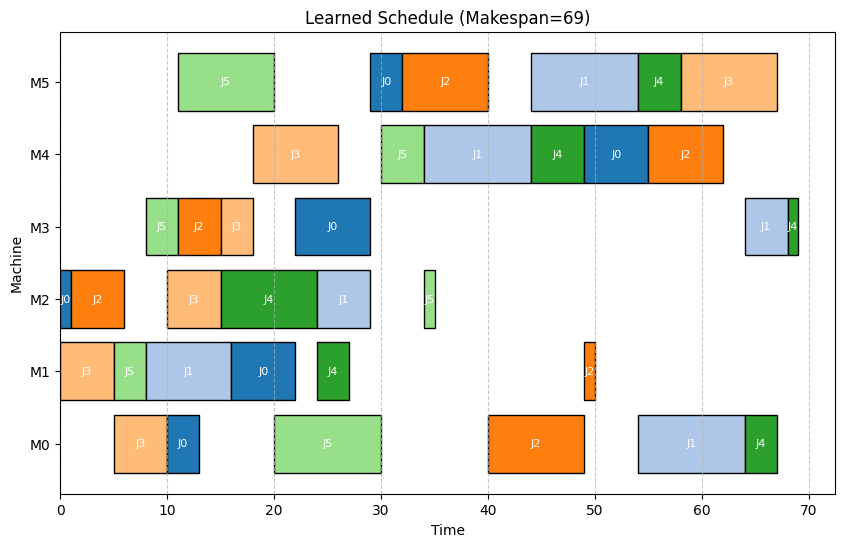

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# ---------------- CONFIG ----------------
device = torch.device("cpu")
print(f"Using device: {device}")

# ---------------- ENVIRONMENT ----------------
class JobShopEnvironment:
    def __init__(self, jobs_data):
        self.jobs_data = jobs_data
        self.n_jobs = len(jobs_data)
        self.n_machines = len(jobs_data[0])
        self.optimal_target = 55  # Known optimal for FT06
        self.reset()

    def reset(self):
        self.machine_times = [0] * self.n_machines
        self.job_completion_times = [0] * self.n_jobs
        self.job_progress = [0] * self.n_jobs
        self.total_operations = 0
        self.max_operations = self.n_jobs * self.n_machines
        self.policy_seq = []
        return self.get_state()

    def get_valid_actions(self):
        return [job_id for job_id in range(self.n_jobs)
                if self.job_progress[job_id] < self.n_machines]

    def get_state(self):
        state = []
        progress = self.total_operations / self.max_operations
        state.append(progress)

        current_makespan = max(self.machine_times) if self.machine_times else 0
        state.append(current_makespan / 200.0)

        total_work = sum(self.machine_times)
        if total_work > 0:
            machine_util = [t / total_work for t in self.machine_times]
        else:
            machine_util = [0] * self.n_machines
        state.extend(machine_util)

        job_ratios = [prog / self.n_machines for prog in self.job_progress]
        state.extend(job_ratios)

        for job_id in range(self.n_jobs):
            if self.job_progress[job_id] < self.n_machines:
                machine, duration = self.jobs_data[job_id][self.job_progress[job_id]]
                machine_available = self.machine_times[machine]
                job_available = self.job_completion_times[job_id]
                wait_time = max(0, machine_available - job_available)
                state.extend([
                    machine / self.n_machines,
                    duration / 20.0,
                    wait_time / 100.0,
                    machine_available / 100.0
                ])
            else:
                state.extend([0, 0, 0, 0])

        if max(self.machine_times) > 0:
            balance = 1.0 - (np.std(self.machine_times) / np.mean(self.machine_times))
        else:
            balance = 1.0
        state.append(balance)

        return np.array(state, dtype=np.float32)

    def step(self, action):
        valid_actions = self.get_valid_actions()
        if not valid_actions or action not in valid_actions:
            return self.get_state(), -100, False

        job_id = action
        operation_idx = self.job_progress[job_id]
        machine, duration = self.jobs_data[job_id][operation_idx]

        prev_makespan = max(self.machine_times)
        prev_machine_balance = np.std(self.machine_times)

        start_time = max(self.machine_times[machine], self.job_completion_times[job_id])
        end_time = start_time + duration

        self.machine_times[machine] = end_time
        self.job_completion_times[job_id] = end_time
        self.job_progress[job_id] += 1
        self.total_operations += 1
        self.policy_seq.append(job_id)

        done = all(progress >= self.n_machines for progress in self.job_progress)

        if done:
            makespan = max(self.machine_times)
            # Strong final reward
            reward = 1000 - (makespan - self.optimal_target) * 20
        else:
            current_makespan = max(self.machine_times)
            makespan_increase = current_makespan - prev_makespan
            current_balance = np.std(self.machine_times)

            progress_reward = 1
            makespan_penalty = -makespan_increase * 0.5
            balance_reward = 2 if current_balance < prev_machine_balance else -1
            makespan_penalty_abs = -current_makespan * 0.01

            reward = progress_reward + makespan_penalty + balance_reward + makespan_penalty_abs

        return self.get_state(), reward, done

    def get_makespan(self):
        return max(self.machine_times)

# ---------------- Q-NETWORK ----------------
class ImprovedQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.network(x)

# ---------------- AGENT ----------------
class ImprovedDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = ImprovedQNetwork(state_dim, action_dim)
        self.target_network = ImprovedQNetwork(state_dim, action_dim)
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=50, factor=0.8)

        self.memory = deque(maxlen=20000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.99995  # slower decay
        self.epsilon_min = 0.05
        self.update_target_freq = 100
        self.update_count = 0

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
        if not valid_actions:
            return 0
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)[0]
            masked_q_values = q_values.clone()
            for i in range(len(q_values)):
                if i not in valid_actions:
                    masked_q_values[i] = -1e9
            return masked_q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return None
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + self.gamma * next_q * ~dones

        loss = nn.SmoothL1Loss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.update_target_freq == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

# ---------------- TRAINING ----------------
def train_improved_rl(jobs_data, episodes=1500):
    env = JobShopEnvironment(jobs_data)
    state_dim = len(env.get_state())
    action_dim = env.n_jobs
    agent = ImprovedDQNAgent(state_dim, action_dim)

    rewards_history, makespan_history, loss_history = [], [], []
    best_makespan = float('inf')
    best_episode = 0
    best_policy_seq = []

    for episode in range(episodes):
        state = env.reset()
        total_reward, done, step_count = 0, False, 0

        while not done and step_count < 200:
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if len(agent.memory) > agent.batch_size:
                loss = agent.train()
                if loss is not None:
                    loss_history.append(loss)
                    if episode % 5 == 0:
                        agent.scheduler.step(loss)

        makespan = env.get_makespan()
        rewards_history.append(total_reward)
        makespan_history.append(makespan)

        if makespan < best_makespan:
            best_makespan = makespan
            best_episode = episode
            best_policy_seq = env.policy_seq.copy()
            if best_makespan <= env.optimal_target:
                print(f"🎉 OPTIMAL FOUND at episode {episode}, makespan={best_makespan}")
                break

        if episode % 10 == 0:
            recent_avg = np.mean(makespan_history[-50:]) if len(makespan_history) >= 50 else np.mean(makespan_history)
            print(f"Episode {episode}: Best={best_makespan} (ep {best_episode}), Recent Avg={recent_avg:.1f}, ε={agent.epsilon:.3f}")

    return agent, best_makespan, best_policy_seq, makespan_history, loss_history

# ---------------- GANTT CHART ----------------
def plot_gantt(seq, jobs_data, best_makespan):
    n_jobs = len(jobs_data)
    n_machines = len(jobs_data[0])
    ops_per_job = len(jobs_data[0])
    machine_times = [0] * n_machines
    job_times = [0] * n_jobs
    op_indices = [0] * n_jobs
    schedule = []

    for job in seq:
        if op_indices[job] >= ops_per_job:
            continue
        op_idx = op_indices[job]
        machine, duration = jobs_data[job][op_idx]
        start = max(machine_times[machine], job_times[job])
        finish = start + duration
        schedule.append((job, machine, start, finish))
        machine_times[machine] = finish
        job_times[job] = finish
        op_indices[job] += 1

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors
    for job_id, machine, start, finish in schedule:
        ax.barh(machine, finish - start, left=start, color=colors[job_id % len(colors)], edgecolor='black')
        ax.text(start + (finish - start)/2, machine, f"J{job_id}", va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f"M{m}" for m in range(n_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(f"Learned Schedule (Makespan={best_makespan})")
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# ---------------- MAIN ----------------
if __name__ == "__main__":
    jobs_data = [
        [(2,1),(0,3),(1,6),(3,7),(5,3),(4,6)],
        [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
        [(2,5),(3,4),(5,8),(0,9),(1,1),(4,7)],
        [(1,5),(0,5),(2,5),(3,3),(4,8),(5,9)],
        [(2,9),(1,3),(4,5),(5,4),(0,3),(3,1)],
        [(1,3),(3,3),(5,9),(0,10),(4,4),(2,1)],
    ]

    agent, best_makespan, best_policy_seq, makespan_history, loss_history = train_improved_rl(jobs_data, episodes=200)
    print(f"\n Best makespan: {best_makespan}")

    if best_policy_seq:
        plot_gantt(best_policy_seq, jobs_data, best_makespan)